# Exercise 9: Knowledge Extraction from a Convolutional Neural Network

In the following exercise we will train a convolutional neural network to classify electron microscopy images of Drosophila synapses, based on which neurotransmitter they contain. We will then train a CycleGAN and use a method called Discriminative Attribution from Counterfactuals (DAC) to understand how the network performs its classification, effectively going back from prediction to image data.

![synister.png](assets/synister.png)

### Acknowledgments

This notebook was written by Jan Funke and modified by Tri Nguyen and Diane Adjavon, using code from Nils Eckstein and a modified version of the [CycleGAN](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) implementation.


<div class="alert alert-danger">
Set your python kernel to <code>09_knowledge_extraction</code>
</div>

<div class="alert alert-block alert-success"><h1>Start here (AKA checkpoint 0)</h1>

</div>

## Part 1: Image Classification

### Training an image classifier
In this section, we will implement and train a VGG classifier to classify images of synapses into one of six classes, corresponding to the neurotransmitter type that is released at the synapse: GABA, acethylcholine, glutamate, octopamine, serotonin, and dopamine.


The data we use for this exercise is located in `data/raw/synapses`, where we have one subdirectory for each neurotransmitter type. Look at a few examples to familiarize yourself with the dataset. You will notice that the dataset is not balanced, i.e., we have much more examples of one class versus another one.

This class imbalance is problematic for training a classifier. Imagine that 99% of our images are of one class, then the classifier would do really well predicting this class all the time, without having learnt anything of substance. It is therefore important to balance the dataset, i.e., present the same number of images per class to the classifier during training.

First, we split the available images into a train, validation, and test dataset with proportions of 0.7, 0.15, and 0.15, respectively. Each image should be returned as a 2D `numpy` array with float values between 0 and 1. The label for each image should be the name of the directory for this class (e.g., `0_gaba`).


In [1]:
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch
import numpy as np

transform = transforms.Compose(
    [
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

# create a dataset for all images of all classes
full_dataset = ImageFolder(root="data/raw/synapses", transform=transform)

# Rename the classes
full_dataset.classes = [x.split("_")[-1] for x in full_dataset.classes]
class_to_idx = {x.split("_")[-1]: v for x, v in full_dataset.class_to_idx.items()}
full_dataset.class_to_idx = class_to_idx

# randomly split the dataset into train, validation, and test
num_images = len(full_dataset)
# ~70% for training
num_training = int(0.7 * num_images)
# ~15% for validation
num_validation = int(0.15 * num_images)
# ~15% for testing
num_test = num_images - (num_training + num_validation)
# split the data randomly (but with a fixed random seed)
train_dataset, validation_dataset, test_dataset = random_split(
    full_dataset,
    [num_training, num_validation, num_test],
    generator=torch.Generator().manual_seed(23061912),
)

#### Creating a Balanced Dataloader

Below define a `sampler` that samples images of classes with skewed probabilities to account for the different number of items in each class.

The sampler
- Counts the number of samples in each class
- Gets the weight-per-label as an inverse of the frequency
- Get the weight-per-sample
- Create a `WeightedRandomSampler` based on these weights

In [2]:
# compute class weights in training dataset for balanced sampling
def balanced_sampler(dataset):
    # Get a list of targets from the dataset
    if isinstance(dataset, torch.utils.data.Subset):
        # A Subset is a specific type of dataset, which does not directly have access to the targets.
        targets = torch.tensor(dataset.dataset.targets)[dataset.indices]
    else:
        targets = dataset.targets

    counts = torch.bincount(targets)  # Count the number of samples for each class
    label_weights = (
        1.0 / counts
    )  # Get the weight-per-label as an inverse of the frequency
    weights = label_weights[targets]  # Get the weight-per-sample

    # Optional: Print the Counts and Weights to make sure lower frequency classes have higher weights
    print("Number of images per class:")
    for c, n, w in zip(full_dataset.classes, counts, label_weights):
        print(f"\t{c}:\tn={n}\tweight={w}")

    sampler = WeightedRandomSampler(
        weights, len(weights)
    )  # Create a sampler based on these weights
    return sampler


sampler = balanced_sampler(train_dataset)

Number of images per class:
	gaba:	n=31646	weight=3.159957122988999e-05
	acetylcholine:	n=9847	weight=0.00010155377094633877
	glutamate:	n=7135	weight=0.00014015416672918946
	serotonin:	n=4649	weight=0.00021510002261493355
	octopamine:	n=1822	weight=0.0005488474271260202
	dopamine:	n=9327	weight=0.0001072156082955189


We make a `torch` `DataLoader` that takes our `sampler` to create batches of eight images and their corresponding labels.
Each image should be randomly and equally selected from the six available classes (i.e., for each image sample pick a random class, then pick a random image from this class).

We additionally create a validation data loader and a test data loader.
These do not need to be sampled in a special way, and can load more images at once because the evaluation pass is less memory intensive than the training pass.

In [3]:
# this data loader will serve 8 images in a "mini-batch" at a time
dataloader = DataLoader(train_dataset, batch_size=8, drop_last=True, sampler=sampler)

The cell below visualizes a single, randomly chosen batch from the training data loader. Feel free to execute this cell multiple times to get a feeling for the dataset and that your sampler gives batches of evenly distributed synapse types.

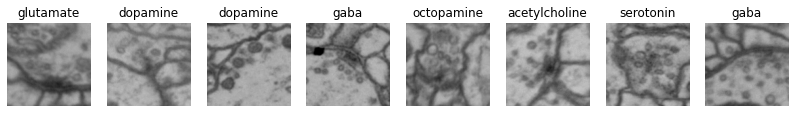

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt


def show_batch(x, y):
    fig, axs = plt.subplots(1, x.shape[0], figsize=(14, 14), sharey=True)
    for i in range(x.shape[0]):
        axs[i].imshow(np.squeeze(x[i]), cmap="gray", vmin=-1, vmax=1)
        axs[i].set_title(train_dataset.dataset.classes[y[i].item()])
        axs[i].axis('off')
    plt.show()


# show a random batch from the data loader
# (run this cell repeatedly to see different batches)
for x, y in dataloader:
    show_batch(x, y)
    break

#### Creating a VGG Network, Loss

We will use a VGG network to classify the synapse images. The input to the network will be a 2D image as provided by your dataloader. The output will be a vector of six floats, corresponding to the probability of the input to belong to the six classes.

We have implemented a VGG network below.
</div>

In [5]:
class Vgg2D(torch.nn.Module):
    def __init__(
        self,
        input_size,
        fmaps=12,
        downsample_factors=[(2, 2), (2, 2), (2, 2), (2, 2)],
        output_classes=6,
    ):
        super(Vgg2D, self).__init__()

        self.input_size = input_size

        current_fmaps, h, w = tuple(input_size)
        current_size = (h, w)

        features = []
        for i in range(len(downsample_factors)):
            features += [
                torch.nn.Conv2d(current_fmaps, fmaps, kernel_size=3, padding=1),
                torch.nn.BatchNorm2d(fmaps),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(fmaps, fmaps, kernel_size=3, padding=1),
                torch.nn.BatchNorm2d(fmaps),
                torch.nn.ReLU(inplace=True),
                torch.nn.MaxPool2d(downsample_factors[i]),
            ]

            current_fmaps = fmaps
            fmaps *= 2

            size = tuple(
                int(c / d) for c, d in zip(current_size, downsample_factors[i])
            )
            check = (
                s * d == c for s, d, c in zip(size, downsample_factors[i], current_size)
            )
            assert all(check), "Can not downsample %s by chosen downsample factor" % (
                current_size,
            )
            current_size = size

        self.features = torch.nn.Sequential(*features)

        classifier = [
            torch.nn.Linear(current_size[0] * current_size[1] * current_fmaps, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(),
            torch.nn.Linear(4096, output_classes),
        ]

        self.classifier = torch.nn.Sequential(*classifier)

    def forward(self, raw):
        # compute features
        f = self.features(raw)
        f = f.view(f.size(0), -1)

        # classify
        y = self.classifier(f)

        return y

We'll start by creating the VGG with the default parameters and push it to a GPU if there is one available. Then we'll define the training loss and optimizer.
The training and evaluation loops have been defined for you, so after that just train your network!

In [6]:
# get the size of our images
for x, y in train_dataset:
    input_size = x.shape
    break

# create the model to train
model = Vgg2D(input_size)

In [7]:
# use a GPU, if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Will use device {device} for training")

Will use device cuda for training


<div class="alert alert-block alert-info"><h4>Task 1.1: Train the VGG Network</h4>

- Choose a loss
- Create an Adam optimizer and set its learning rate
</div>

In [8]:
loss = ...
optimizer = ...

In [9]:
############################
# Solution to Task 1.3 #
############################
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

The next cell defines some convenience functions for training, validation, and testing:

In [10]:
from tqdm import tqdm


def train(dataloader):
    """Train the model for one epoch."""

    # set the model into train mode
    model.train()

    epoch_loss = 0

    num_batches = 0
    for x, y in tqdm(dataloader, "train"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        y_pred = model(x)
        l = loss(y_pred, y)
        l.backward()

        optimizer.step()

        epoch_loss += l
        num_batches += 1

    return epoch_loss / num_batches

<div class="alert alert-block alert-info"><h4>Task 1.2: Create a prediction loop</h4>

We now have a classifier that can discriminate between images of different types. If you used the images we provided, the classifier is not perfect (you should get an accuracy of around 80%), but pretty good considering that there are six different types of images.

To understand the performance of the classifier, we need to run predictions on the validation dataset so that we can get accuracy and eventually a confusiom natrix.


TODO
Modify the `evaluation` so that it returns a paired list of predicted class vs ground truth to produce a confusion matrix. You'll need to do the following steps.
- Get the model output for the batch of data `(x, y)`
- Turn the model output into a probability
- Get the class predictions from the probabilities
- Add the class predictions to a list of all predictions
- Add the ground truths to a list of all ground truths

</div>


In [59]:
# TODO: return a paired list of predicted class vs ground-truth to produce a confusion matrix
from tqdm import tqdm
from sklearn.metrics import accuracy_score


def predict(dataset, name, batch_size=32):
    # These data laoders serve images in a "mini-batch"
    dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=False)
    #
    ground_truths = []
    predictions = []
    for x, y in tqdm(dataloader, name):
        x, y = x.to(device), y.to(device)

        # Get the model output
        # Turn the model output into a probability
        # Get the class predictions from the probabilities

        predictions.extend(...)  # TODO add predictions to the list
        ground_truths.extend(...)  # TODO add ground truths to the list
    return np.array(predictions), np.array(ground_truths)


predictions, ground_truths = predict(test_dataset, "Test")
print("Current test accuracy of the network", accuracy_score(ground_truth, prediction))

Test:   0%|          | 0/432 [00:00<?, ?it/s]


TypeError: 'ellipsis' object is not iterable

In [60]:
#########################
# Solution for Task 1.4 #
#########################

from tqdm import tqdm
from sklearn.metrics import accuracy_score


def predict(dataset, name, batch_size=32):
    # These data laoders serve images in a "mini-batch"
    dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=False)
    
    ground_truths = []
    predictions = []
    for x, y in tqdm(dataloader, name):
        x, y = x.to(device), y.to(device)

        # Get the model output
        logits = model(x)
        # Turn the model output into a probability
        probs = torch.nn.Softmax(dim=1)(logits)
        # Get the class predictions from the probabilities
        batch_predictions = torch.argmax(probs, dim=1)

        # append predictions and groundtruth to our big list,
        # converting `tensor` objects to simple values through .item()
        predictions.extend(batch_predictions.cpu().numpy())
        ground_truths.extend(y.cpu().numpy())

    return np.array(predictions), np.array(ground_truths)


prediction, ground_truth = predict(test_dataset, "Test")
print("Current test accuracy of the network", accuracy_score(ground_truth, prediction))

Test: 100%|██████████| 432/432 [00:14<00:00, 29.39it/s]

Current test accuracy of the network 0.768450785833273


We are ready to train. After each epoch (roughly going through each training image once), we report the training loss and the validation accuracy.

In [13]:
for epoch in range(3):
    epoch_loss = train(dataloader)
    print(f"Epoch {epoch}, training loss={epoch_loss}")

    predictions, gt = predict(validation_dataset, "Validation")
    accuracy = accuracy_score(gt, predictions) 
    print(f"Epoch {epoch}, validation accuracy={accuracy}")

train: 100%|██████████| 8053/8053 [02:23<00:00, 55.97it/s]


Epoch 0, training loss=1.4428281784057617


Validation: 100%|██████████| 432/432 [00:13<00:00, 31.03it/s]


Epoch 0, validation accuracy=0.42998913437160446


train: 100%|██████████| 8053/8053 [02:18<00:00, 58.32it/s]


Epoch 1, training loss=1.116437315940857


Validation: 100%|██████████| 432/432 [00:15<00:00, 28.74it/s]


Epoch 1, validation accuracy=0.4709887721839913


train: 100%|██████████| 8053/8053 [02:18<00:00, 58.24it/s]


Epoch 2, training loss=0.9176948070526123


Validation: 100%|██████████| 432/432 [00:14<00:00, 29.57it/s]

Epoch 2, validation accuracy=0.504092720028975


Let's watch your model train!

<img src="assets/model_train.jpg" alt="drawing" width="500px"/>

And now, let's test it!

In [14]:
predictions, ground_truths = predict(test_dataset, "Test")
accuracy = accuracy_score(ground_truths, predictions)
print(f"Final test accuracy: {accuracy}")

Test: 100%|██████████| 432/432 [00:14<00:00, 29.30it/s]

Final test accuracy: 0.5011950459911639


If you're unhappy with the accuracy above (which you should be...) we pre-trained a model for you for many more epochs. You can load it with the next cell.

In [15]:
# TODO change this to True and run this cell if you want a shortcut
yes_I_want_the_pretrained_model = True

if yes_I_want_the_pretrained_model:
    checkpoint = torch.load(
        "checkpoints/synapses/classifier/vgg_checkpoint", map_location=device
    )
    model.load_state_dict(checkpoint["model_state_dict"])

#### Construct a confusion matrix

We now have a classifier that can discriminate between images of different types. If you used the images we provided, the classifier is not perfect (you should get an accuracy of around 80%), but pretty good considering that there are six different types of images.

To understand the performance of the classifier beyond a single accuracy number, we should build a confusion matrix that can more elucidate which classes are more/less misclassified and which classes are those wrong predictions confused with. 
</div>


Let's plot the confusion matrix.

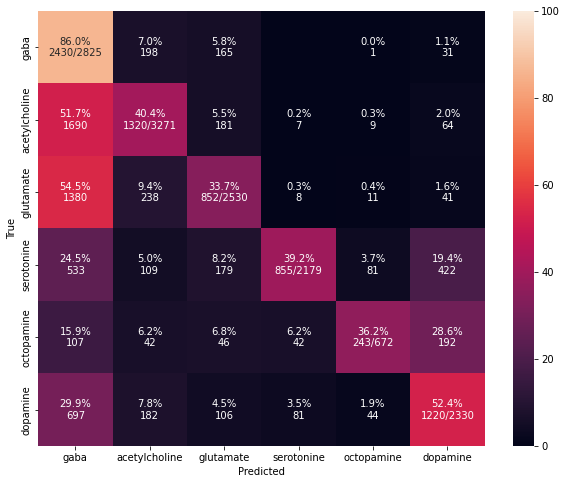

In [16]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np


# Plot confusion matrix
# orginally from Runqi Yang;
# see https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
def cm_analysis(y_true, y_pred, names, labels=None, title=None, figsize=(10, 8)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.

    Parameters
    ----------
      confusion_matrix: np.array
      labels: list
          List of integer values to determine which classes to consider.
      names:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if labels is not None:
        assert len(names) == len(labels)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = "%.1f%%\n%d/%d" % (p, c, s)
            elif c == 0:
                annot[i, j] = ""
            else:
                annot[i, j] = "%.1f%%\n%d" % (p, c)
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(
        cm_perc, annot=annot, fmt="", vmax=100, xticklabels=names, yticklabels=names
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    if title:
        ax.set_title(title)


names = ["gaba", "acetylcholine", "glutamate", "serotonine", "octopamine", "dopamine"]
cm_analysis(predictions, ground_truths, names=names)

<div class="alert alert-banner alert-warning">
<h4>Questions</h4>

- What observations can we make from the confusion matrix?
- Does the classifier do better on some synapse classes than other?
- If you have time later, which ideas would you try to train a better predictor?

Let us know your thoughts on the course chat.
</div>

<div class="alert alert-block alert-success"><h1>Checkpoint 1</h1>

We now have:
- A classifier that is pretty good at predicting neurotransmitters from EM images.

This is surprising, since we could not (yet) have made these predictions manually! If you're skeptical, feel free to explore the data a bit more and see for yourself if you can tell the difference betwee, say, GABAergic and glutamatergic synapses.

So this is an interesting situation: The VGG network knows something we don't quite know. In the next section, we will see how we can find and then visualize the relevant differences between images of different types.

This concludes the first section. Let us know on the exercise chat if you have arrived here.
</div>

## Part 2: Masking the relevant part of the image

In this section we will make a first attempt at highlight differences between the "real" and "fake" images that are most important to change the decision of the classifier.


### Attributions through integrated gradients

Attribution is the process of finding out, based on the output of a neural network, which pixels in the input are (most) responsible. Another way of thinking about it is: which pixels would need to change in order for the network's output to change.

Here we will look at an example of an attribution method called [Integrated Gradients](https://captum.ai/docs/extension/integrated_gradients). If you have a bit of time, have a look at this [super fun exploration of attribution methods](https://distill.pub/2020/attribution-baselines/), especially the explanations on Integrated Gradients.

In [17]:
x, y = next(iter(dataloader))
x = x.to(device)
y = y.to(device)

<div class="alert alert-block alert-info"><h4>Task 2.1 Get an attribution</h4>

In this next part, we will get attributions on single batch. We use a library called [captum](https://captum.ai), and focus on the `IntegratedGradients` method.
Create an `IntegratedGradients` object and run attribution on `x,y` obtained above.

</div>

In [18]:
from captum.attr import IntegratedGradients

############### Task 2.1 TODO ############
# Create an integrated gradients object.
integrated_gradients = ...

# Generated attributions on integrated gradients
attributions = ...

In [19]:
#########################
# Solution for Task 2.1 #
#########################

# Create an integrated gradients object.
integrated_gradients = IntegratedGradients(model)

# Generated attributions on integrated gradients
attributions = integrated_gradients.attribute(x, target=y)

In [20]:
attributions = (
    attributions.cpu().numpy()
)  # Move the attributions from the GPU to the CPU, and turn then into numpy arrays for future processing

Here is an example for an image, and its corresponding attribution.

In [21]:
from captum.attr import visualization as viz

def unnormalize(image):
    return 0.5*image + 0.5

def visualize_attribution(attribution, original_image):
    attribution = np.transpose(attribution, (1, 2, 0))
    original_image = np.transpose(unnormalize(original_image), (1, 2, 0))
    
    viz.visualize_image_attr_multiple(
        attribution, 
        original_image, 
        methods=["blended_heat_map", "heat_map"],
        signs=["absolute_value", "absolute_value"],
        show_colorbar=True, 
        titles=["Original and Attribution", "Attribution"],
        use_pyplot=True
    )

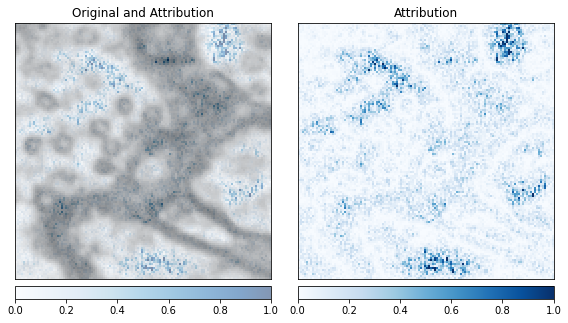

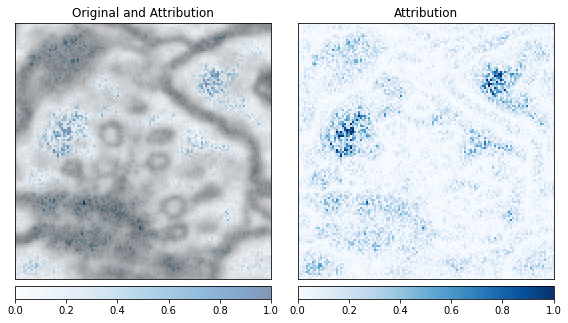

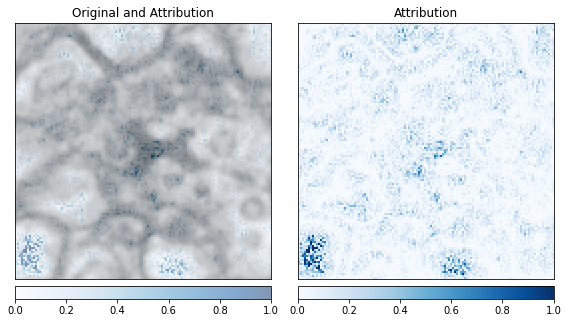

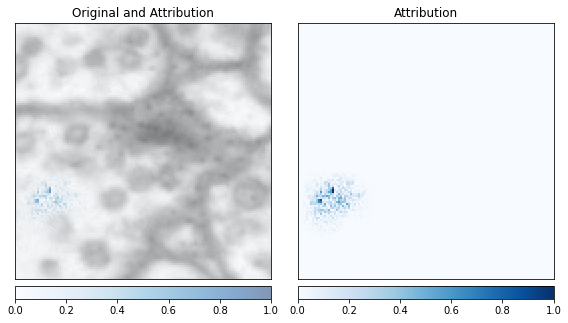

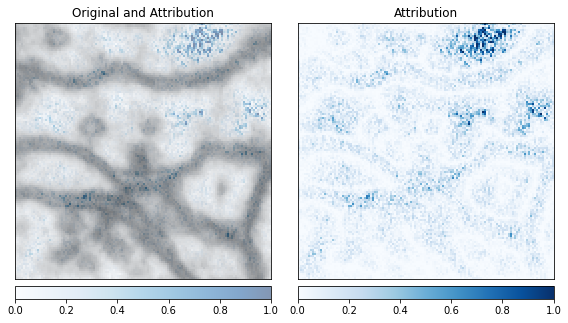

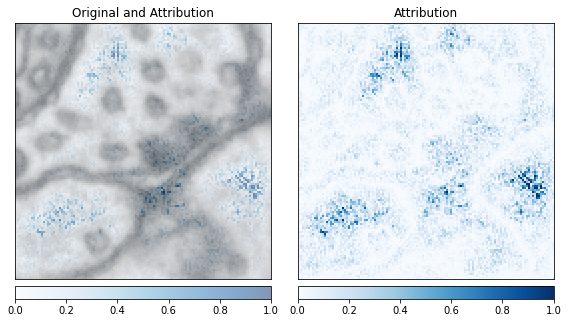

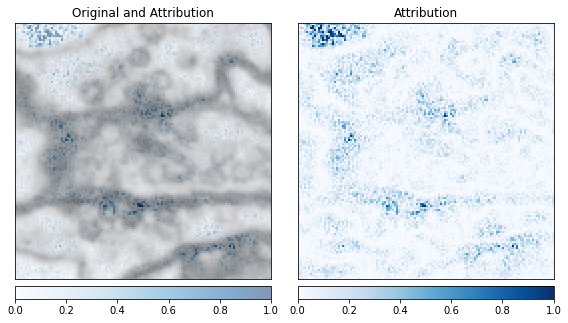

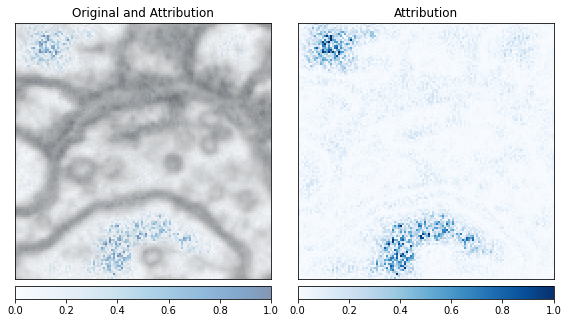

In [22]:
for attr, im in zip(attributions, x.cpu().numpy()):
    visualize_attribution(attr, im)

### Smoothing the attribution into a mask

The attributions that we see are grainy and difficult to interpret because they are a pixel-wise attribution. We apply some smoothing and thresholding on the attributions so that they represent region masks rather than pixel masks. The following code is runnable with no modification.

In [23]:
import cv2
import copy


def smooth_attribution(attrs, struc=10, sigma=11):
    # Morphological closing and Gaussian Blur
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (struc, struc))
    mask = cv2.morphologyEx(attrs[0], cv2.MORPH_CLOSE, kernel)
    mask_cp = copy.deepcopy(mask)
    mask_weight = cv2.GaussianBlur(mask_cp.astype(float), (sigma, sigma), 0)
    return mask_weight[np.newaxis]

def get_mask(attrs, threshold=0.5):
    smoothed = smooth_attribution(attrs)
    return smoothed > (threshold * smoothed.max())

def interactive_attribution(idx=0):
    image = x[idx].cpu().numpy()
    attrs = attributions[idx]
    mask = smooth_attribution(attrs)
    visualize_attribution(mask, image)
    return

<div class="alert alert-block alert-info"><h4>Task 2.2 Visualizing the results</h4>

The code above creates a small widget to interact with the results of this analysis. You'll see in the masking code that there is a free parameter called "threshold". This threshold affects the size of the mask. If you modify the threshold below, you will see that different objects appear and disappear.
You can also look at different images by sliding over the index.

</div>

In [24]:
from ipywidgets import interact

interact(
    interactive_attribution,
    idx=(0, dataloader.batch_size - 1),
)

interactive(children=(IntSlider(value=0, description='idx', max=7), Output()), _dom_classes=('widget-interact'…

<function __main__.interactive_attribution(idx=0)>

HELP! I Can't see any interactive setup!! 

I got you... just uncomment the next cell and run it to see all of the samples at once.

In [26]:
# HELP! I Can't see any interative setup!!!
# for attr, im in zip(attributions, x.cpu().numpy()):
#     visualize_attribution(smooth_attribution(attr), im)

<div class="alert alert-banner alert-warning">
<h4>Questions</h4>

- Are there some recognisable objects or parts of the synapse that show up in several examples?
- Are there some objects that seem secondary because they only appear at certain threshold levels?

Tell us what you see on the chat!
</div>

<div class="alert alert-block alert-info"><h4>BONUS Task 2.3: changing the baseline</h4>

Many existing attribution algorithms are comparative: they show which pixels of the input are responsible for a network output *compared to a baseline*.
The baseline is often set to an all 0 tensor, but the choice of the baseline affects the output.
(For an interactive illustration of how the baseline affects the output, see [this Distill paper](https://distill.pub/2020/attribution-baselines/))

You can change the baseline used by the `integrated_gradients` object.

Use the command:
```
?integrated_gradients.attribute
```
To get more details about how to include the baseline.

Try using the code above to change the baseline and see how this affects the output. Do different features get highlighted?
For example you can try:
- Random noise as a baseline
- Another image from the dataset
- A blurred/noisy version of the original image as a baseline.
</div>

<div class="alert alert-block alert-info"><h4>BONUS Task 2.4: Using different attributions.</h4>



[`captum`](https://captum.ai/tutorials/Resnet_TorchVision_Interpret) has access to various different attribution algorithms.

Replace `IntegratedGradients` with different attribution methods. Are they consistent with each other?
</div>

<div class="alert alert-block alert-success"><h1>Checkpoint 2</h1>
Let us know on the exercise chat when you've reached this point!

At this point we have:
<ol>
    <li>Trained a classifier that can predict neurotransmitters from EM-slices of synapses.</li>
    <li>Found a way to mask the parts of the image that seem to be relevant for the classification, using integrated gradients.</li>
</ol>
</div>

## Part 3: Train a GAN to Translate Images

To gain insight into how the trained network classify images, we will use [Discriminative Attribution from Counterfactuals](https://arxiv.org/abs/2109.13412), a feature attribution with counterfactual explanations methodology. This method employs a so-called CycleGAN to translate images from one class to another to make counterfactual explanations.

In this example, we will train a CycleGAN network that translates GABAergic synapses to acetylcholine synapses (you can also train other pairs too by changing the classes below).

In [27]:
def class_dir(name):
    return f"{class_to_idx[name]}_{name}"

classes = ["gaba", "acetylcholine"]

### Training a GAN

Yes, really!

<div><h4>Creating a specialized dataset</h4>

The CycleGAN works on only 2 classes at a time, but our full dataset has 6. Below, we will use the `Subset` dataset from `torch.utils.data` to get the data from these two classes.

A `Subset` is created as follows:
```
subset = Subset(dataset, indices)
```

And the chosen indices can be obtained again using `subset.indices`.

Run the cell below to generate the datasets:
- `gan_train_dataset`
- `gan_test_dataset`
- `gan_val_dataset`

We will use them below to train the CycleGAN.
</div>

In [28]:
# Utility functions to get a subset of classes
def get_indices(dataset, classes):
    """Get the indices of elements of classA and classB in the dataset."""
    indices = []
    for cl in classes:
        indices.append(torch.tensor(dataset.targets) == class_to_idx[cl])
    logical_or = sum(indices) > 0
    return torch.where(logical_or)[0]


def set_intersection(a_indices, b_indices):
    """Get intersection of two sets

    Parameters
    ----------
    a_indices: torch.Tensor
    b_indices: torch.Tensor

    Returns
    -------
    intersection: torch.Tensor
        The elements contained in both a_indices and b_indices.
    """
    a_cat_b, counts = torch.cat([a_indices, b_indices]).unique(return_counts=True)
    intersection = a_cat_b[torch.where(counts.gt(1))]
    return intersection


# Getting training, testing, and validation indices
gan_idx = get_indices(full_dataset, classes)

gan_train_idx = set_intersection(torch.tensor(train_dataset.indices), gan_idx)
gan_test_idx = set_intersection(torch.tensor(test_dataset.indices), gan_idx)
gan_val_idx = set_intersection(torch.tensor(validation_dataset.indices), gan_idx)

# Checking that the subsets are complete
assert len(gan_train_idx) + len(gan_test_idx) + len(gan_val_idx) == len(gan_idx)

# Generate three datasets based on the above indices.
from torch.utils.data import Subset

gan_train_dataset = Subset(full_dataset, gan_train_idx)
gan_test_dataset = Subset(full_dataset, gan_test_idx)
gan_val_dataset = Subset(full_dataset, gan_val_idx)

### The model

![cycle.png](assets/cyclegan.png)

In the following, we create a [CycleGAN model](https://arxiv.org/pdf/1703.10593.pdf). It is a Generative Adversarial model that is trained to turn one class of images X (for us, GABA) into a different class of images Y (for us, Acetylcholine).

It has two generators:
   - Generator G takes a GABA image and tries to turn it into an image of an Acetylcholine synapse. When given an image that is already showing an Acetylcholine synapse, G should just re-create the same image: these are the `identities`.
   - Generator F takes a Acetylcholine image and tries to turn it into an image of an GABA synapse. When given an image that is already showing a GABA synapse, F should just re-create the same image: these are the `identities`.


When in training mode, the CycleGAN will also create a `reconstruction`. These are images that are passed through both generators.
For example, a GABA image will first be transformed by G to Acetylcholine, then F will turn it back into GABA.
This is achieved by training the network with a cycle-consistency loss. In our example, this is an L2 loss between the `real` GABA image and the `reconstruction` GABA image.

But how do we force the generators to change the class of the input image? We use a discriminator for each.
   - DX tries to recognize fake GABA images: F will need to create images realistic and GABAergic enough to trick it.
   - DY tries to recognize fake Acetylcholine images: G will need to create images realistic and cholinergic enough to trick it.

In [29]:
from torch import nn
import functools
from cycle_gan.models.networks import ResnetGenerator, NLayerDiscriminator, GANLoss


class CycleGAN(nn.Module):
    """Cycle GAN

    Has:
    - Two class names
    - Two Generators
    - Two Discriminators
    """

    def __init__(
        self, class1, class2, input_nc=1, output_nc=1, ngf=64, ndf=64, use_dropout=False
    ):
        """
        class1: str
            Label of the first class
        class2: str
            Label of the second class
        """
        super().__init__()
        norm_layer = functools.partial(
            nn.InstanceNorm2d, affine=False, track_running_stats=False
        )
        self.classes = [class1, class2]
        self.inverse_keys = {
            class1: class2,
            class2: class1,
        }  # i.e. what is the other key?
        self.generators = nn.ModuleDict(
            {
                classname: ResnetGenerator(
                    input_nc,
                    output_nc,
                    ngf,
                    norm_layer=norm_layer,
                    use_dropout=use_dropout,
                    n_blocks=9,
                )
                for classname in self.classes
            }
        )
        self.discriminators = nn.ModuleDict(
            {
                classname: NLayerDiscriminator(
                    input_nc, ndf, n_layers=3, norm_layer=norm_layer
                )
                for classname in self.classes
            }
        )

    def forward(self, x, train=True):
        """Creates fakes from the reals.

        Parameters
        ----------
        x: dict
            classname -> images
        train: boolean
            If false, only the counterfactuals are generated and returned.
            Defaults to True.

        Returns
        -------
        fakes: dict
            classname -> images of counterfactual images
        identities: dict
            classname -> images of images passed through their corresponding generator, if train is True
            For example, images of class1 are passed through the generator that creates class1.
            These should be identical to the input.
            Not returned if `train` is `False`
        reconstructions
            classname -> images of reconstructed images (full cycle), if train is True.
            Not returned if `train` is `False`
        """
        fakes = {}
        identities = {}
        reconstructions = {}
        for k, batch in x.items():
            inv_k = self.inverse_keys[k]
            # Counterfactual: class changes
            fakes[inv_k] = self.generators[inv_k](batch)
            if train:
                # From counterfactual back to original, class changes again
                reconstructions[k] = self.generators[k](fakes[inv_k])
                # Identites: class does not change
                identities[k] = self.generators[k](batch)
        if train:
            return fakes, identities, reconstructions
        return fakes

    def discriminate(self, x):
        """Get discriminator opinion on x

        Parameters
        ----------
        x: dict
            classname -> images
        """
        discrimination = {}
        for k, batch in x.items():
            discrimination[k] = self.discriminators[k](batch)
        return discrimination

In [30]:
cyclegan = CycleGAN(*classes)
cyclegan.to(device)
print(f"Will use device {device} for training")

Will use device cuda for training


You will notice above that the `CycleGAN` takes an input in the form of a dictionary, but our datasets and data-loaders return the data in the form of two tensors. Below are two utility functions that will swap from data from one to the other.

In [31]:
# Utility function to go to/from dictionaries/x,y tensors
def get_as_xy(dictionary):
    x = torch.cat([arr for arr in dictionary.values()])
    y = []
    for k, v in dictionary.items():
        val = class_labels[k]
        y += [
            val,
        ] * len(v)
    y = torch.Tensor(y).to(x.device)
    return x, y


def get_as_dictionary(x, y):
    dictionary = {}
    for k in classes:
        val = class_to_idx[k]
        # Get all of the indices for this class
        this_class_indices = torch.where(y == val)
        dictionary[k] = x[this_class_indices]
    return dictionary


#### Creating a training loop 

Now that we have a model, our next task is to create a training loop for the CycleGAN. This is a bit more difficult than the training loop for our classifier.

Here are some of the things to keep in mind during the next task.

1. The CycleGAN is (obviously) a GAN: a Generative Adversarial Network. What makes an adversarial network "adversarial" is that two different networks are working against each other. The loss that is used to optimize this is in our exercise `criterionGAN`. Although the specifics of this loss is beyond the score of this notebook, the idea is simple: the `criterionGAN` compares the output of the discriminator to a boolean-valued target. If we want the discriminator to think that it has seen a real image, we set the target to `True`. If we want the  discriminator to think that it has seen a generated image, we set the target to `False`. Note that it isn't important here whether the image *is* real, but **whether we want the discriminator to think it is real at that point**. (This will be important very soon 😉)

2. Since the two networks are fighting each other, it is important to make sure that neither of them can cheat with information espionage. The CycleGAN implementation below is a turn-by-turn fight: we train the generator(s) and the discriminator(s) in alternating steps. When a model is not training, we will restrict its access to information by using `set_requries_grad` to `False`.

In [32]:
from cycle_gan.util.image_pool import ImagePool

In [33]:
criterionIdt = nn.L1Loss()
criterionCycle = nn.L1Loss()
criterionGAN = GANLoss("lsgan")
criterionGAN.to(device)

lambda_idt = 1
pool_size = 32

lambdas = {k: 1 for k in classes}
image_pools = {classname: ImagePool(pool_size) for classname in classes}

optimizer_g = torch.optim.Adam(cyclegan.generators.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(cyclegan.discriminators.parameters(), lr=1e-4)

<div class="alert alert-block alert-info"><h4>Set up the training losses and gradients</h4>

In the code below, there are several spots with multiple options. Choose from among these, and delete or comment out the incorrect option.
1. In `generator_step`: Choose whether the target to the`criterionGAN` should be `True` or `False`.
2. In `discriminator_step`: Choose the target to the `criterionGAN` (note that there are two this time, one for the real images and one for the generated images)
3. In `train_gan`: `set_requires_grad` correctly.
</div>

In [34]:
def set_requires_grad(module, value=True):
    """Sets `requires_grad` on a `module`'s parameters to `value`"""
    for param in module.parameters():
        param.requires_grad = value


def generator_step(cyclegan, reals):
    """Calculate the loss for generators G_X and G_Y"""
    # Get all generated images
    fakes, identities, reconstructions = cyclegan(reals)
    # Get discriminator opinion
    discrimination = cyclegan.discriminate(fakes)
    loss = 0
    for k in classes:
        # Identity loss
        # G_A should be identity if real_B is fed: ||G_A(B) - B||
        loss_idt = criterionIdt(identities[k], reals[k]) * lambdas[k] * lambda_idt

        # GAN loss D_A(G_A(A))
        #################### TODO Choice 1 #####################
        # OPTION 1
        # loss_G = criterionGAN(discrimination[k], False)
        # OPTION2
        # loss_G = criterionGAN(discrimination[k], True)
        #########################################################

        # Forward cycle loss || G_B(G_A(A)) - A||
        loss_cycle = criterionCycle(reconstructions[k], reals[k]) * lambdas[k]
        # combined loss and calculate gradients
        loss += loss_G + loss_cycle + loss_idt
    loss.backward()


def discriminator_step(cyclegan, reals):
    """Calculate the loss for the discriminators D_X and D_Y"""
    fakes, identities, reconstructions = cyclegan(reals)
    preds_real = cyclegan.discriminate(reals)
    # Get fakes from pool
    fakes = {k: v.detach() for k, v in fakes.items()}
    preds_fake = cyclegan.discriminate(fakes)
    loss = 0
    for k in classes:
        #################### TODO Choice 2 #####################
        # OPTION 1
        # loss_real = criterionGAN(preds_real[k], True)
        # loss_fake = criterionGAN(preds_fake[k], False)
        # OPTION 2
        # loss_real = criterionGAN(preds_real[k], False)
        # loss_fake = criterionGAN(preds_fake[k], True)
        #########################################################

        loss += (loss_real + loss_fake) * 0.5
    loss.backward()


def train_gan(reals):
    """Optimize the network parameters on a batch of images.

    reals: Dict[str, torch.Tensor]
        Classname -> Tensor dictionary of images.
    """
    #################### TODO Choice 3 #####################
    # OPTION 1
    # set_requires_grad(cyclegan.generators, True)
    # set_requires_grad(cyclegan.discriminators, False)
    # OPTION 2
    # set_requires_grad(cyclegan.generators, False)
    # set_requires_grad(cyclegan.discriminators, True)
    ##########################################################

    optimizer_g.zero_grad()
    generator_step(cyclegan, reals)
    optimizer_g.step()

    #################### TODO (still) choice 3 #####################
    # OPTION 1
    # set_requires_grad(cyclegan.generators, True)
    # set_requires_grad(cyclegan.discriminators, False)
    # OPTION 2
    # set_requires_grad(cyclegan.generators, False)
    # set_requires_grad(cyclegan.discriminators, True)
    #################################################################

    optimizer_d.zero_grad()
    discriminator_step(cyclegan, reals)
    optimizer_d.step()

In [35]:
# Solution
def set_requires_grad(module, value=True):
    """Sets `requires_grad` on a `module`'s parameters to `value`"""
    for param in module.parameters():
        param.requires_grad = value


def generator_step(cyclegan, reals):
    """Calculate the loss for generators G_X and G_Y"""
    # Get all generated images
    fakes, identities, reconstructions = cyclegan(reals)
    # Get discriminator opinion
    discrimination = cyclegan.discriminate(fakes)
    loss = 0
    for k in classes:
        # Identity loss
        # G_A should be identity if real_B is fed: ||G_A(B) - B||
        loss_idt = criterionIdt(identities[k], reals[k]) * lambdas[k] * lambda_idt

        # GAN loss D_A(G_A(A))
        #################### TODO Choice 1 #####################
        # OPTION 1
        # loss_G = criterionGAN(discrimination[k], False)
        # OPTION2
        loss_G = criterionGAN(discrimination[k], True)
        #########################################################

        # Forward cycle loss || G_B(G_A(A)) - A||
        loss_cycle = criterionCycle(reconstructions[k], reals[k]) * lambdas[k]
        # combined loss and calculate gradients
        loss += loss_G + loss_cycle + loss_idt
    loss.backward()


def discriminator_step(cyclegan, reals):
    """Calculate the loss for the discriminators D_X and D_Y"""
    fakes, identities, reconstructions = cyclegan(reals)
    preds_real = cyclegan.discriminate(reals)
    # Get fakes from pool
    fakes = {k: v.detach() for k, v in fakes.items()}
    preds_fake = cyclegan.discriminate(fakes)
    loss = 0
    for k in classes:
        #################### TODO Choice 2 #####################
        # OPTION 1
        loss_real = criterionGAN(preds_real[k], True)
        loss_fake = criterionGAN(preds_fake[k], False)
        # OPTION 2
        # loss_real = criterionGAN(preds_real[k], False)
        # loss_fake = criterionGAN(preds_fake[k], True)
        #########################################################

        loss += (loss_real + loss_fake) * 0.5
    loss.backward()


def train_gan(reals):
    """Optimize the network parameters on a batch of images.

    reals: Dict[str, torch.Tensor]
        Classname -> Tensor dictionary of images.
    """
    #################### TODO Choice 3 #####################
    # OPTION 1
    set_requires_grad(cyclegan.generators, True)
    set_requires_grad(cyclegan.discriminators, False)
    # OPTION 2
    # set_requires_grad(cyclegan.generators, False)
    # set_requires_grad(cyclegan.discriminators, True)
    ##########################################################

    optimizer_g.zero_grad()
    generator_step(cyclegan, reals)
    optimizer_g.step()

    #################### TODO (still) choice 3 #####################
    # OPTION 1
    # set_requires_grad(cyclegan.generators, True)
    # set_requires_grad(cyclegan.discriminators, False)
    # OPTION 2
    set_requires_grad(cyclegan.generators, False)
    set_requires_grad(cyclegan.discriminators, True)
    #################################################################

    optimizer_d.zero_grad()
    discriminator_step(cyclegan, reals)
    optimizer_d.step()

Let's add a quick plotting function before we begin training...

In [36]:
def plot_gan_output(sample=None):
    # Get the input from the test dataset
    if sample is None:
        i = np.random.randint(len(gan_test_dataset))
        x, y = gan_test_dataset[i]
        x = x.to(device)
        reals = {classes[y]: x}
    else:
        reals = sample

    with torch.no_grad():
        fakes, identities, reconstructions = cyclegan(reals)
    inverse_keys = cyclegan.inverse_keys
    for k in reals.keys():
        inv_k = inverse_keys[k]
        for i in range(len(reals[k])):
            fig, (ax, ax_fake, ax_id, ax_recon) = plt.subplots(1, 4)
            ax.imshow(reals[k][i].squeeze().cpu(), cmap="gray")
            ax_fake.imshow(fakes[inv_k][i].squeeze().cpu(), cmap="gray")
            ax_id.imshow(identities[k][i].squeeze().cpu(), cmap="gray")
            ax_recon.imshow(reconstructions[k][i].squeeze().cpu(), cmap="gray")
            # Name the axes
            ax.set_title(f"{k.capitalize()}")
            ax_fake.set_title("Counterfactual")
            ax_id.set_title("Identity")
            ax_recon.set_title("Reconstruction")
            for ax in [ax, ax_fake, ax_id, ax_recon]:
                ax.axis("off")

<div class="alert alert-banner alert-info"><h4>Task 3.2</h4>
Training! Let's train the CycleGAN one batch a time, plotting the output every so often to see how it is getting on. 

While you watch the model train, consider whether you think it will be successful at generating counterfactuals in the number of steps we give it. What is the minimum number of iterations you think are needed for this to work, and how much time do yo uthink it will take?
</div>

In [37]:
# Get a balanced sampler that only considers the two classes
sampler = balanced_sampler(gan_train_dataset)
dataloader = DataLoader(
    gan_train_dataset, batch_size=8, drop_last=True, sampler=sampler
)

Number of images per class:
	gaba:	n=31646	weight=3.159957122988999e-05
	acetylcholine:	n=9847	weight=0.00010155377094633877


In [38]:
# Number of iterations to train for (note: this is not *nearly* enough to get ideal results)
iterations = 500
# Determines how often to plot outputs to see how the network is doing. I recommend scaling your `print_every` to your `iterations`.
# For example, if you're running `iterations=5` you can `print_every=1`, but `iterations=1000` and `print_every=1` will be a lot of prints.
print_every = 100

  0%|          | 0/500 [00:00<?, ?it/s]

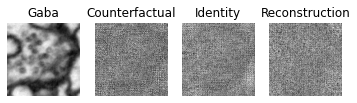

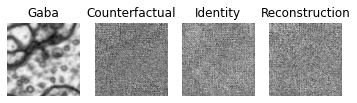

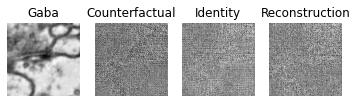

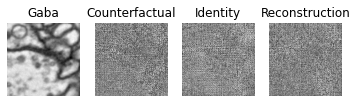

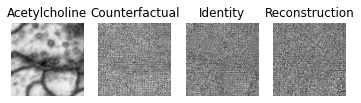

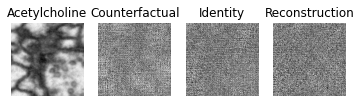

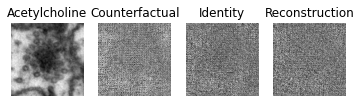

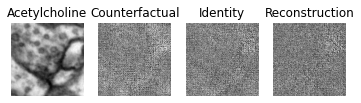

 20%|██        | 100/500 [00:38<02:28,  2.69it/s]

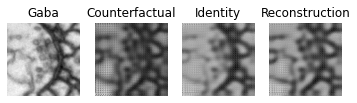

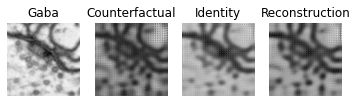

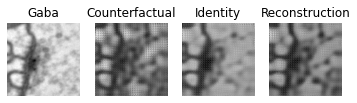

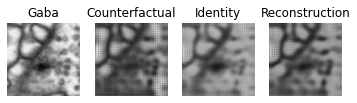

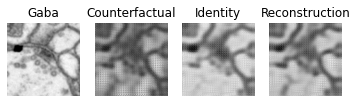

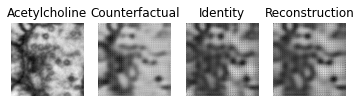

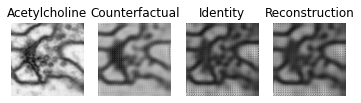

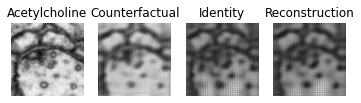

 40%|████      | 200/500 [01:17<01:55,  2.60it/s]

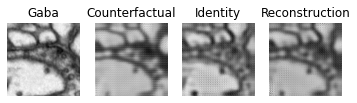

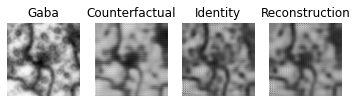

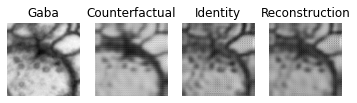

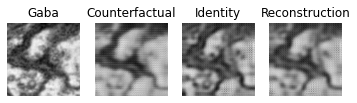

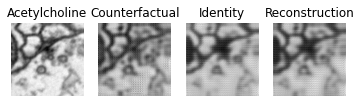

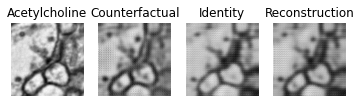

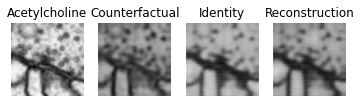

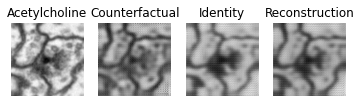

 60%|██████    | 300/500 [01:57<01:18,  2.53it/s]

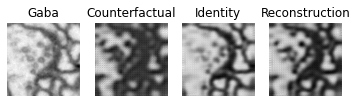

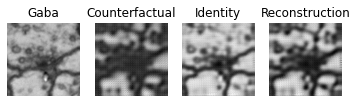

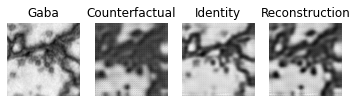

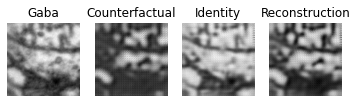

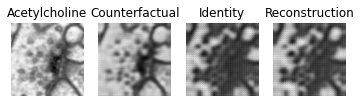

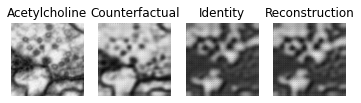

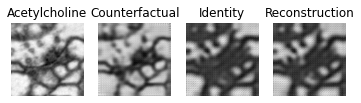

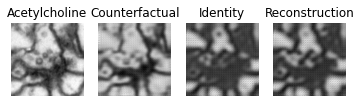

 80%|████████  | 400/500 [02:37<00:39,  2.51it/s]

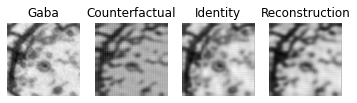

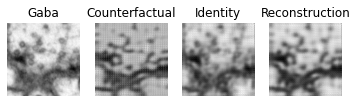

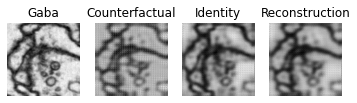

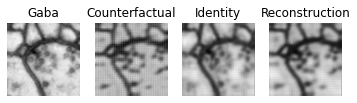

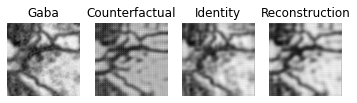

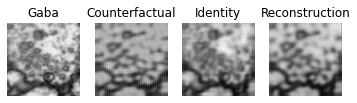

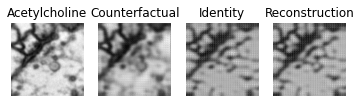

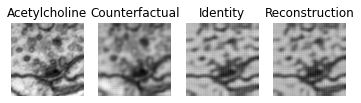

100%|██████████| 500/500 [03:18<00:00,  2.52it/s]


In [39]:
for i in tqdm(range(iterations)):
    x, y = next(iter(dataloader))
    x = x.to(device)
    y = y.to(device)
    real = get_as_dictionary(x, y)
    train_gan(real)
    if i % print_every == 0:
        cyclegan.eval()  # Set to eval to speed up the plotting
        plot_gan_output(sample=real)
        cyclegan.train()  # Set back to train!
        plt.show()

...this time again.

<img src="assets/model_train.jpg" alt="drawing" width="500px"/>

<div class="alert alert-block alert-success"><h1>Checkpoint 3</h1>
You've now learned the basics of what makes up a CycleGAN, and details on how to perform adversarial training.
The same method can be used to create a CycleGAN with different basic elements.
For example, you can change the archictecture of the generators, or of the discriminator to better fit your data in the future.

You know the drill... let us know on the exercise chat!
</div>

# Part 4: Evaluating the GAN


### That was fun!... let's load a pre-trained model

Training the CycleGAN takes a lot longer than the few iterations that we did above. Since we don't have that kind of time, we are going to load a pre-trained model (for reference, this pre-trained model was trained for 7 days...).

To continue, interrupt the kernel and continue with the next one, which will just use one of the pretrained CycleGAN models for the synapse dataset.

In [40]:
from pathlib import Path
import torch


def load_pretrained(model, path, classA, classB):
    """Load the pre-trained models from the path"""
    directory = Path(path).expanduser() / f"{classA}_{classB}"
    # Load generators
    model.generators[classB].load_state_dict(
        torch.load(directory / "latest_net_G_A.pth")
    )
    model.generators[classA].load_state_dict(
        torch.load(directory / "latest_net_G_B.pth")
    )
    # Load discriminators
    model.discriminators[classA].load_state_dict(
        torch.load(directory / "latest_net_D_A.pth")
    )
    model.discriminators[classB].load_state_dict(
        torch.load(directory / "latest_net_D_B.pth")
    )


load_pretrained(cyclegan, "./checkpoints/synapses/cycle_gan/", *classes)

Let's look at some examples. Can you pick up on the differences between original, the counter-factual, and the reconstruction?

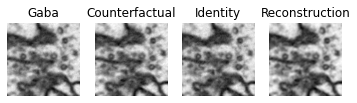

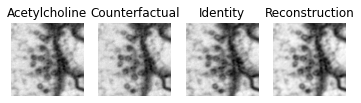

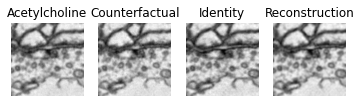

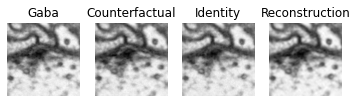

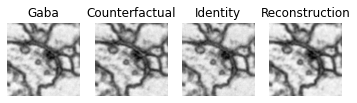

In [41]:
for i in range(5):
    plot_gan_output()

We're going to apply the CycleGAN to our test dataset, and save the results to be reused later.

In [42]:
dataloader = DataLoader(gan_test_dataset, batch_size=32)

In [43]:
from skimage.io import imsave


def unnormalize(image):
    return ((0.5 * image + 0.5) * 255).astype(np.uint8)


@torch.no_grad()
def apply_gan(dataloader, directory):
    """Run CycleGAN on a dataloader and save images to a directory."""
    directory = Path(directory)
    inverse_keys = cyclegan.inverse_keys
    cyclegan.eval()
    batch_size = dataloader.batch_size
    n_sample = 0
    for batch, (x, y) in enumerate(tqdm(dataloader)):
        reals = get_as_dictionary(x.to(device), y.to(device))
        fakes, _, recons = cyclegan(reals)
        for k in reals.keys():
            inv_k = inverse_keys[k]
            (directory / f"real/{k}").mkdir(parents=True, exist_ok=True)
            (directory / f"reconstructed/{k}").mkdir(parents=True, exist_ok=True)
            (directory / f"counterfactual/{k}").mkdir(parents=True, exist_ok=True)
            for i, (im_real, im_fake, im_recon) in enumerate(
                zip(reals[k], fakes[inv_k], recons[k])
            ):
                # Save real synapse images
                imsave(
                    directory / f"real/{k}/{k}_{inv_k}_{n_sample}.png",
                    unnormalize(im_real.cpu().numpy().squeeze()),
                )
                # Save fake synapse images
                imsave(
                    directory / f"reconstructed/{k}/{k}_{inv_k}_{n_sample}.png",
                    unnormalize(im_recon.cpu().numpy().squeeze()),
                )
                # Save counterfactual synapse images
                imsave(
                    directory / f"counterfactual/{k}/{k}_{inv_k}_{n_sample}.png",
                    unnormalize(im_fake.cpu().numpy().squeeze()),
                )
                # Count
                n_sample += 1
    return

In [44]:
apply_gan(dataloader, "test_images/")

100%|██████████| 279/279 [02:04<00:00,  2.24it/s]


In [45]:
# Clean-up the gpu's memory a bit to avoid Out-of-Memory errors
# cyclegan = cyclegan.cpu()
# torch.cuda.empty_cache()

### Evaluating the GAN

The first thing to find out is whether the CycleGAN is successfully converting the images from one neurotransmitter to another.
We will do this by running the classifier that we trained earlier on generated data.

The data were saved in a directory called `test_images`.


In [46]:
def make_dataset(directory):
    """Create a dataset from a directory of images with the classes in the same order as the VGG's output.

    Parameters
    ----------
    directory: str
        The root directory of the images. It should contain sub-directories named after the classes, in which images are stored.
    """
    # Make a dataset with the classes in the correct order
    limited_classes = {k: v for k, v in class_to_idx.items() if k in classes}
    dataset = ImageFolder(root=directory, transform=transform)
    samples = ImageFolder.make_dataset(
        directory, class_to_idx=limited_classes, extensions=".png"
    )
    # Sort samples by name
    samples = sorted(samples, key=lambda s: s[0].split("_")[-1])
    dataset.classes = classes
    dataset.class_to_idx = limited_classes
    dataset.samples = samples
    dataset.targets = [s[1] for s in samples]
    return dataset

<div class="alert alert-block alert-info"><h4>Task 4.1 Get the classifier accuracy on CycleGAN outputs</h4>

Using the saved images, we're going to figure out how good our CycleGAN is at generating images of a new class!

The images (`real`, `reconstructed`, and `counterfactual`) are saved in the `test_images/` directory. Before you start the exercise, have a look at how this directory is organized.

TODO
- Create a dataset for the three different image types that we saved above
    - real
    - reconstructed
    - counterfactual
</div>

In [47]:
# Dataset of real images
ds_real = ...
# Dataset of reconstructed images (full cycle)
ds_recon = ...
# Datset of counterfactuals (half-cycle)
ds_counterfactual = ...

In [48]:
############################
# Solution to Task 4.2 #
############################

# Dataset of real images
ds_real = make_dataset("test_images/real/")
# Dataset of reconstructed images (full cycle)
ds_recon = make_dataset("test_images/reconstructed/")
# Datset of counterfactuals (half-cycle)
ds_counterfactual = make_dataset("test_images/counterfactual/")

<div class="alert alert-banner alert-warning">
We get the following accuracies:

1. `accuracy_real`: Accuracy of the classifier on the real images, just for the two classes used in the GAN
2. `accuracy_recon`: Accuracy of the classifier on the reconstruction.
3. `accuracy_counter`: Accuracy of the classifier on the counterfactual images.
<h4>Questions</h4>

- In a perfect world, what value would we expect for `accuracy_recon`? What do we compare it to and why is it higher/lower?
- How well is it translating from one class to another? Do we expect `accuracy_counter` to be large or small? Do we want it to be large or small? Why?

Let us know your insights on the exercise chat.
</div>

In [117]:
cf_pred, cf_gt = predict(ds_counterfactual, "Counterfactuals")
recon_pred, recon_gt = predict(ds_recon, "Reconstructions")
real_pred, real_gt = predict(ds_real, "Real images")

# Get the accuracies
accuracy_real = accuracy_score(real_gt, real_pred)
accuracy_recon = accuracy_score(recon_gt, recon_pred)
accuracy_cf = accuracy_score(cf_gt, cf_pred)

print(
    f"Accuracy real: {accuracy_real}\nAccuracy reconstruction: {accuracy_recon}\nAccuracy counterfactuals: {accuracy_cf}\n"
)

Real images: 100%|██████████| 279/279 [00:06<00:00, 41.21it/s]

Accuracy real: 0.7680932108447233
Accuracy reconstruction: 0.7147658525655389
Accuracy counterfactuals: 0.3462917320188214



We're going to look at the confusion matrices for the counterfactuals, and compare it to that of the real images.

The confusion matrix of the classifier on the counterfactuals


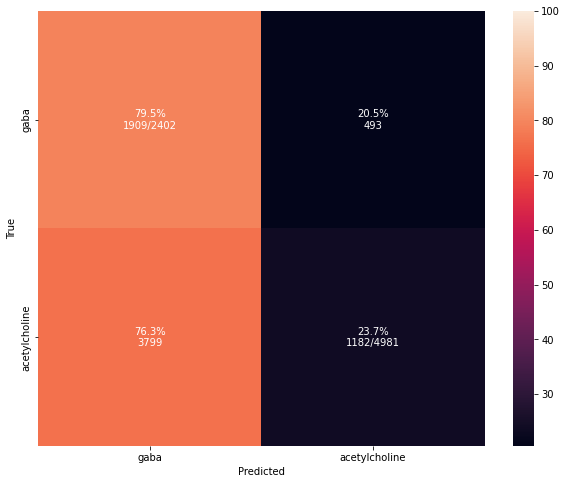

In [118]:
labels = [class_to_idx[i] for i in classes]
print("The confusion matrix of the classifier on the counterfactuals")
cm_analysis(cf_pred, cf_gt, names=classes, labels=labels)

The confusion matrix on the real images... for comparison


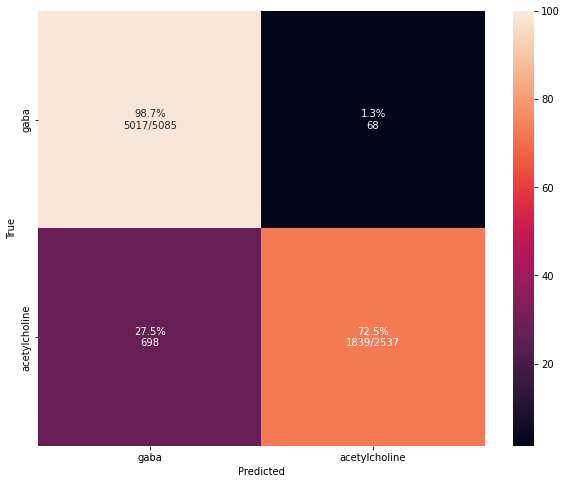

In [119]:
print("The confusion matrix on the real images... for comparison")
cm_analysis(real_pred, real_gt, names=classes, labels=labels)

<div class="alert alert-banner alert-warning">
<h4>Questions</h4>

- What would you expect the confusion matrix for the counterfactuals to look like? Why?
- Do the two directions of the CycleGAN work equally as well?
- Can you think of anything that might have made it more difficult, or easier, to translate in a one direction vs the other?

</div>

<div class="alert alert-block alert-success"><h1>Checkpoint 4</h1>
 We have seen that our CycleGAN network has successfully translated some of the synapses from one class to the other, but there are clearly some things to look out for!
Take the time to think about the questions above before moving on...

This is the end of Section 3. Let us know on the exercise chat if you have reached this point!
</div>

## Part 5: Highlighting Class-Relevant Differences

At this point we have:
- A classifier that can differentiate between neurotransmitters from EM images of synapses
- A vague idea of which parts of the images it thinks are important for this classification
- A CycleGAN that is sometimes able to trick the classifier with barely perceptible changes

What we don't know, is *how* the CycleGAN is modifying the images to change their class.

To start to answer this question, we will use a [Discriminative Attribution from Counterfactuals](https://arxiv.org/abs/2109.13412) method to highlight differences between the "real" and "fake" images that are most important to change the decision of the classifier.

### Visualizing the results

<div class="alert alert-block alert-info"><h4>Task 5.1 Get sucessfully converted samples</h4>
The CycleGAN is able to convert some, but not all images into their target types.
In order to observe and highlight useful differences, we want to observe our attribution method at work only on those examples of synapses:
<ol>
    <li> That were correctly classified originally</li>
    <li>Whose counterfactuals were also correctly classified</li>
</ol>

TODO
- Get a boolean description of the `real` samples that were correctly predicted
- Get the target class for the `counterfactual` images (Hint: It isn't `cf_gt`!)
- Get a boolean description of the `cf` samples that have the target class
</div>

In [120]:
####### Task 5.1 TODO #######

# Get the samples where the real is correct
correct_real = ...

# HINT GABA is class 1 and ACh is class 0
target = ...

# Get the samples where the counterfactual has reached the target
correct_cf = ...

# Successful conversions
success = np.logical_and(correct_real, correct_cf)


In [121]:
########################
# Solution to Task 5.1 #
########################

# Get the samples where the real is correct
correct_real = (real_pred == real_gt)

# HINT GABA is class 1 and ACh is class 0
target = 1 - real_gt

# Get the samples where the counterfactual has reached the target
correct_cf = (cf_pred == target)

# Successful conversions
success = np.where(np.logical_and(correct_real, correct_cf))[0]

# Create datasets with only the successes
cf_success_ds = Subset(ds_counterfactual, success)
real_success_ds = Subset(ds_real, success)


To check that we have got it right, let us get the accuracy on the best 100 vs the worst 100 samples:

In [122]:
model = model.to("cuda")

In [123]:
real_true, real_pred = predict(real_success_ds, "Real")
cf_true, cf_pred = predict(cf_success_ds, "Counterfactuals")

print("Accuracy of the classifier on successful real images", accuracy_score(real_true, real_pred))
print("Accuracy of the classifier on successful counterfactual images", accuracy_score(cf_true, cf_pred))

Counterfactuals: 100%|██████████| 96/96 [00:02<00:00, 41.00it/s]

Accuracy of the classifier on successful real images 1.0
Accuracy of the classifier on successful counterfactual images 0.0


### Creating hybrids from attributions

Now that we have a set of successfully translated counterfactuals, we can use them as a baseline for our attribution.
If you remember from earlier, `IntegratedGradients` does a interpolation between the model gradients at the baseline and the model gradients at the sample. Here, we're also going to be doing an interpolation between the baseline image and the sample image, creating a hybrid!

To do this, we will take the sample image and mask out all of the pixels in the attribution. We will then replace these masked out pixels by the equivalent values in the counterfactual. So we'll have a hybrid image that is like the original everywhere except in the areas that matter for classification.

In [124]:
dataloader_real = DataLoader(real_success_ds, batch_size=10)
dataloader_counter = DataLoader(cf_success_ds, batch_size=10)

In [125]:
%%time
with torch.no_grad():
    model.to(device)
    # Create an integrated gradients object.
    # integrated_gradients = IntegratedGradients(model)
    # Generated attributions on integrated gradients
    attributions = np.vstack(
        [
            integrated_gradients.attribute(
                real.to(device),
                target=target.to(device),
                baselines=counterfactual.to(device),
            )
            .cpu()
            .numpy()
            for (real, target), (counterfactual, _) in zip(
                dataloader_real, dataloader_counter
            )
        ]
    )

CPU times: user 1min 1s, sys: 686 ms, total: 1min 2s
Wall time: 1min 2s


In [126]:
# Functions for creating an interactive visualization of our attributions
model.cpu()

import matplotlib

cmap = matplotlib.cm.get_cmap("viridis")
colors = cmap([0, 255])


@torch.no_grad()
def get_classifications(image, counter, hybrid):
    model.eval()
    class_idx = [full_dataset.classes.index(c) for c in classes]
    tensor = torch.from_numpy(np.stack([image, counter, hybrid])).float()
    with torch.no_grad():
        logits = model(tensor)[:, class_idx]
        probs = torch.nn.Softmax(dim=1)(logits)
        pred, counter_pred, hybrid_pred = probs
    return pred.numpy(), counter_pred.numpy(), hybrid_pred.numpy()


def interactive_counterfactuals(idx, threshold=0.1):
    image = real_success_ds[idx][0].numpy()
    counter = cf_success_ds[idx][0].numpy()
    mask = get_mask(attributions[idx], threshold)
    hybrid = (1 - mask) * image + mask * counter
    nan_mask = copy.deepcopy(mask)
    nan_mask[nan_mask != 0] = 1
    nan_mask[nan_mask == 0] = np.nan
    # PLOT
    fig, axes = plt.subplot_mosaic(
        """
                                   mmm.ooo.ccc.hhh
                                   mmm.ooo.ccc.hhh
                                   mmm.ooo.ccc.hhh
                                   ....ggg.fff.ppp
                                   """,
        figsize=(20, 5),
    )
    # Original
    viz.visualize_image_attr(
        np.transpose(mask, (1, 2, 0)), 
        np.transpose(image,(1, 2, 0)), 
        method="blended_heat_map",
        sign="absolute_value",
        show_colorbar=True, 
        title="Mask",
        use_pyplot=False,
        plt_fig_axis=(fig, axes["m"])
    )
    # Original
    axes["o"].imshow(image.squeeze(), cmap="gray")
    axes["o"].set_title("Original", fontsize=24)
    # Counterfactual
    axes["c"].imshow(counter.squeeze(), cmap="gray")
    axes["c"].set_title("Counterfactual", fontsize=24)
    # Hybrid
    axes["h"].imshow(hybrid.squeeze(), cmap="gray")
    axes["h"].set_title("Hybrid", fontsize=24)
    # Mask
    pred, counter_pred, hybrid_pred = get_classifications(image, counter, hybrid)
    axes["g"].barh(classes, pred, color=colors)
    axes["f"].barh(classes, counter_pred, color=colors)
    axes["p"].barh(classes, hybrid_pred, color=colors)
    for ix in ["m", "o", "c", "h"]:
        axes[ix].axis("off")

    for ix in ["g", "f", "p"]:
        for tick in axes[ix].get_xticklabels():
            tick.set_rotation(90)
        axes[ix].set_xlim(0, 1)

<div class="alert alert-block alert-info"><h4>Task 5.2: Observing the effect of the changes on the classifier</h4>
Below is a small widget to interact with the above analysis. As you change the `threshold`, see how the prediction of the hybrid changes.
At what point does it swap over?

If you want to see different samples, slide through the `idx`.
</div>

In [127]:
interact(interactive_counterfactuals, idx=(0, 99), threshold=(0.0, 1.0, 0.05))

interactive(children=(IntSlider(value=49, description='idx', max=99), FloatSlider(value=0.1, description='thre…

<function __main__.interactive_counterfactuals(idx, threshold=0.1)>

<div class="alert alert-warning">
<h4>Questions</h4>

- Can you find features that define either of the two classes?
-  How consistent are they across the samples?
-  Is there a range of thresholds where most of the hybrids swap over to the target class? (If you want to see that area, try to change the range of thresholds in the slider by setting `threshold=(minimum_value, maximum_value, step_size)`

Feel free to discuss your answers on the exercise chat!
</div>

<div class="alert alert-block alert-success">
    <h1>The End.</h1>
    Go forth and train some GANs!
</div>

## Going Further

Here are some ideas for how to continue with this notebook:

1. Improve the classifier. This code uses a VGG network for the classification. On the synapse dataset, we will get a validation accuracy of around 80%. Try to see if you can improve the classifier accuracy.
    * (easy) Data augmentation: The training code for the classifier is quite simple in this example. Enlarge the amount of available training data by adding augmentations (transpose and mirror the images, add noise, change the intensity, etc.).
    * (easy) Network architecture: The VGG network has a few parameters that one can tune. Try a few to see what difference it makes.
    * (easy) Inspect the classifier predictions: Take random samples from the test dataset and classify them. Show the images together with their predicted and actual labels.
    * (medium) Other networks:  Try different architectures (e.g., a [ResNet](https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/#resnet-from-scratch)) and see if the accuracy can be improved.

2. Explore the CycleGAN.
    * (easy) The example code below shows how to translate between GABA and acetylcholine. Try different combinations. Can you start to see differences between some pairs of classes? Which are the ones where the differences are the most or the least obvious? Can you see any differences that aren't well described by the mask? How would you describe these?

3. Try on your own data!
    * Have a look at how the synapse images are organized in `data/raw/synapses`. Copy the directory structure and use your own images. Depending on your data, you might have to adjust the image size (128x128 for the synapses) and number of channels in the VGG network and CycleGAN code.